# Coordinate testing

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.io import fits

In [2]:
# Test set of binary matches from APW
df1 = pd.DataFrame(fits.getdata('../data/tim-binaries-1.fits'))
df2 = pd.DataFrame(fits.getdata('../data/tim-binaries-2.fits'))

In [10]:
import os
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
import astropy.units as u

dt = 15*u.yr # back to c. 2000
i = 59 # just an example
ra = df1.ra[i]*u.deg - dt*df1.pmra[i]*u.mas/u.yr
dec = df1.dec[i]*u.deg - dt*df1.pmdec[i]*u.mas/u.yr
q = Vizier.query_region(SkyCoord(ra, dec), radius=5*u.arcsec,
                                catalog=['2mass'])
q[0]

_RAJ2000,_DEJ2000,_r,RAJ2000,DEJ2000,errMaj,errMin,errPA,_2MASS,Jmag,Jcmsig,e_Jmag,Jsnr,Hmag,Hcmsig,e_Hmag,Hsnr,Kmag,Kcmsig,e_Kmag,Ksnr,Qflg,Rflg,Bflg,Cflg,Ndet,prox,pxPA,pxCntr,Xflg,Aflg,Cntr,Hemis,Date,Scan,GLON,GLAT,Xscan,JD,Jpsfchi,Hpsfchi,Kpsfchi,Jstdap,e_Jstdap,Hstdap,e_Hstdap,Kstdap,e_Kstdap,edgeNS,edgeEW,edge,dup,use,opt,Dopt,PAopt,Bmag,Rmag,Nopt,extKey,scanKey,coaddKey,coadd,Opt
deg,deg,arcs,deg,deg,arcs,arcs,deg,,mag,mag,mag,,mag,mag,mag,,mag,mag,mag,,,,,,,arcs,deg,,,,,,,,deg,deg,arcs,d,,,,mag,mag,mag,mag,mag,mag,arcs,arcs,,,,,arcs,deg,mag,mag,,,,,,
float64,float64,float64,float64,float64,float32,float32,int16,str17,float32,float32,float32,float64,float32,float32,float32,float64,float32,float32,float32,float64,str3,str3,str3,str3,str6,float32,int16,int64,uint8,uint8,int64,str1,str10,int16,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int16,str2,uint8,uint8,str1,float32,int16,float32,float32,uint8,int32,int32,int32,int16,str3
24.692811,63.717216,4.347,24.692811,63.717216,0.07,0.06,0,01384627+6343019,7.434,0.035,0.039,37053.6,6.993,0.031,0.034,22999.1,6.939,0.029,0.033,13671.6,AAA,111,111,dcc,445544,3.3,122,758578073,0,0,758578061,n,1999-09-28,114,128.143,1.326,-190.5,2451449.9246,--,--,--,--,--,--,--,--,--,8257,64,ne,1,1,T,1.2,78,10.34,9.47,4,--,41900,963686,103,Opt
24.694572,63.716732,1.154,24.694572,63.716732,0.07,0.06,0,01384669+6343002,7.440,0.021,0.027,36849.4,6.967,0.023,0.027,23556.5,6.936,0.031,0.034,13709.5,AAA,111,111,cdd,444444,3.3,302,758578061,0,0,758578073,n,1999-09-28,114,128.144,1.325,-193.3,2451449.9246,--,--,--,--,--,--,--,--,--,8259,62,ne,1,1,T,0.6,58,10.27,9.45,2,--,41900,963686,103,Opt


The closest 2mass source is still 1.15 arcsec away from where this star should be, given the current coords and the proper motion.  What's even stranger is that the Tycho-2 query doesn't seem to match up either:

In [11]:
dt = (2015-1991.5)*u.yr # back to c. 1991.5 (what the Tycho-2 website says was avg. observation epoch)
i = 59
ra = df1.ra[i]*u.deg - dt*df1.pmra[i]*u.mas/u.yr
dec = df1.dec[i]*u.deg - dt*df1.pmdec[i]*u.mas/u.yr
q = Vizier.query_region(SkyCoord(ra, dec), radius=5*u.arcsec,
                                catalog=['tycho2'])
q[0]

_RAJ2000,_DEJ2000,_r,TYC1,TYC2,TYC3,pflag,RAmdeg,DEmdeg,pmRA,pmDE,e_RAmdeg,e_DEmdeg,e_pmRA,e_pmDE,EpRAm,EpDEm,Num,q_RAmdeg,q_DEmdeg,q_pmRA,q_pmDE,BTmag,e_BTmag,VTmag,e_VTmag,prox,TYC,HIP,CCDM,RA_ICRS_,DE_ICRS_,EpRA-1990,EpDE-1990,e_RAdeg,e_DEdeg,posflg,corr
deg,deg,arcs,,,,,deg,deg,mas / yr,mas / yr,mas,mas,mas / yr,mas / yr,yr,yr,,,,,,mag,mag,mag,mag,,,,,deg,deg,yr,yr,mas,mas,,
float64,float64,float64,int16,int16,uint8,str1,float64,float64,float32,float32,int16,int16,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,int16,str1,int32,str3,float64,float64,float32,float32,float32,float32,str1,float32
24.694258,63.716646,1.291,4035,103,2,X,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,10.501,0.032,9.533,0.021,39,T,7670,B,24.69425833,63.71664583,1.48,1.82,17.7,12.4,,-0.1


Still 1.2 arcsec away?  I must be misinterpreting the meaning of either the TGAS coordinates or the proper motions.  Or using astropy incorrectly?

Let's now look at the whole list to see how often a mismatch like this occurs.

In [71]:
from astropy.time import Time

dt = 15 * u.yr

ra_all = df1.ra.values * u.deg - dt*df1.pmra.values*u.mas/u.yr
dec_all = df1.dec.values * u.deg - dt*df1.pmdec.values*u.mas/u.yr
coords = SkyCoord(ra_all, dec_all, frame='icrs')
q_all = Vizier.query_region(coords, radius=2*u.arcsec, catalog=['tycho2'])

In [72]:
df = pd.DataFrame(np.array(q_all[0]))
df.head()

,_q,_RAJ2000,_DEJ2000,_r,TYC1,TYC2,TYC3,pflag,RAmdeg,DEmdeg,...,HIP,CCDM,RA_ICRS_,DE_ICRS_,EpRA-1990,EpDE-1990,e_RAdeg,e_DEdeg,posflg,corr
0,1,42.713319,3.502058,1.658,51,276,1,,42.713319,3.502057,...,-2147483648,,42.712877,3.502181,1.73,1.66,81.900002,96.000000,,-0.1
1,4,42.714897,3.510067,1.756,51,838,1,,42.714923,3.510053,...,-2147483648,,42.714460,3.510190,1.71,1.67,69.099998,78.699997,,-0.1
2,7,49.359947,7.655806,1.404,649,766,1,,49.359947,7.655806,...,15304,,49.359563,7.655821,1.80,1.61,5.100000,6.300000,,-0.2
3,10,49.386584,7.690147,1.443,649,1241,1,,49.386584,7.690146,...,15310,,49.386193,7.690167,1.80,1.60,6.100000,7.900000,,0.0
4,13,55.240636,13.150972,0.384,663,362,1,,55.240635,13.150972,...,-2147483648,,55.240579,13.151029,1.69,1.43,34.000000,47.500000,,0.0


There's a lot of closest matches to Tycho-2 that are off:

In [79]:
c1 = SkyCoord(df.RA_ICRS_.values, df.DE_ICRS_.values, 
                   unit='deg', frame='icrs')
c2 = SkyCoord(df._RAJ2000.values, df._DEJ2000.values, 
                   unit='deg', frame='icrs')
df['distance'] = c1.separation(c2).arcsec

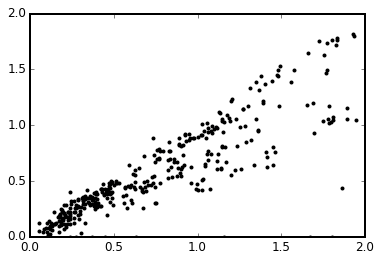

In [85]:
%matplotlib inline
plt.plot(df._r, df.distance, 'o', ms=2);

In [87]:
df[['_r', 'distance']].sort_values(by='_r', ascending=False)

,_r,distance
333,1.947,1.047717
84,1.936,1.801364
83,1.927,1.813585
332,1.895,1.058424
275,1.892,1.158377
141,1.864,0.432961
181,1.834,1.778121
156,1.833,1.766876
155,1.829,1.721965
334,1.811,1.047493


In [59]:
len(df.groupby('_q')._r.min()), (df.groupby('_q')._r.min() > 1).sum()

(408, 162)

In [91]:
df1[['hip','tycho2_id']].head()

,hip,tycho2_id
0,-2147483648,51-276-1
1,-2147483648,51-838-1
2,15304,
3,15310,
4,-2147483648,663-362-1


In [92]:
df_tycho = pd.read_hdf('../data/tycho2.h5')

0

In [111]:
dt = 15 * u.yr
d_ra = (dt*df1.pmra.values*u.mas/u.yr).to('deg').value
d_dec = (dt*df1.pmdec.values*u.mas/u.yr).to('deg').value

df1['ra_j2000_t2'] = df_tycho.ix[df1.tycho2_id, '_RAJ2000'].values + d_ra
df1['dec_j2000_t2'] = df_tycho.ix[df1.tycho2_id, '_DEJ2000'].values + d_dec
df1['ra_icrs_t2'] = df_tycho.ix[df1.tycho2_id, 'RA_ICRS_'].values + d_ra
df1['dec_icrs_t2'] = df_tycho.ix[df1.tycho2_id, 'DE_ICRS_'].values + d_dec


In [113]:
df1[['ra','ra_j2000_t2','ra_icrs_t2']].head()

,ra,ra_j2000_t2,ra_icrs_t2
0,42.714106,42.714117,42.713675
1,42.715726,42.715696,42.715259
2,49.360642,NaN,NaN
3,49.387294,NaN,NaN
4,55.240753,55.240740,55.240683


In [129]:
c1 = SkyCoord(df1.ra.values, df1.dec.values, unit='deg')
c2 = SkyCoord(df1.ra_j2000_t2.values, df1.dec_j2000_t2.values, unit='deg') 
df1['distance_t2_j2000'] = c1.separation(c2) * 3600

In [130]:
c1 = SkyCoord(df1.ra.values, df1.dec.values, unit='deg')
c2 = SkyCoord(df1.ra_icrs_t2.values, df1.dec_icrs_t2.values, unit='deg') 
df1['distance_t2_icrs'] = c1.separation(c2) * 3600

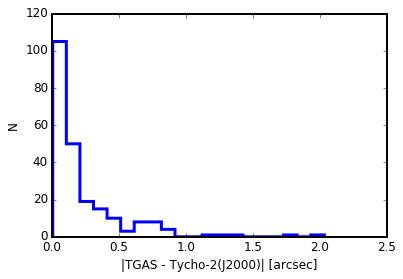

In [131]:
ok = df1['distance_t2_j2000'].notnull()
plt.hist(df1['distance_t2_j2000'][ok], bins=20, histtype='step', lw=3);
plt.ylabel('N')
plt.xlabel('|TGAS - Tycho-2(J2000)| [arcsec]');

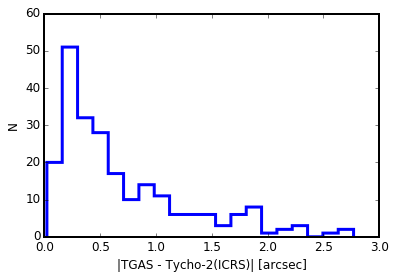

In [132]:
ok = df1['distance_t2_icrs'].notnull()
plt.hist(df1['distance_t2_icrs'][ok], bins=20, histtype='step', lw=3);
plt.ylabel('N')
plt.xlabel('|TGAS - Tycho-2(ICRS)| [arcsec]');